In [0]:
!pip install kaggle

In [0]:
!mkdir ~/.kaggle

In [0]:
!echo '{"username":"<you kaggle user_name>","key":"<your kaggle access_key>"}' > ~/.kaggle/kaggle.json

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d rmisra/news-category-dataset

 35% 9.00M/25.4M [00:00<00:01, 14.7MB/s]
100% 25.4M/25.4M [00:00<00:00, 40.1MB/s]


In [0]:
!ls

news-category-dataset.zip  sample_data


In [0]:
!unzip news-category-dataset.zip

Archive:  news-category-dataset.zip
  inflating: News_Category_Dataset_v2.json  


In [0]:
!ls

News_Category_Dataset_v2.json  news-category-dataset.zip  sample_data


In [0]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# lets try to build a model to classify the news article into its group

In [0]:
import json
import re
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier


from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Flatten, Dense, Dropout
from keras.layers import SimpleRNN
from keras.layers import LSTM

pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [0]:
# reading the news dataset which is in json format

In [0]:
news_text = []
news_label = []

with open('News_Category_Dataset_v2.json') as file:
    for news in file:
        j_news = json.loads(news)
        news_label.append(j_news['category'])
        news_text.append(j_news['headline'] + ' ' + j_news['short_description'])        

In [0]:
len(news_label), len(news_text)

(200853, 200853)

In [0]:
# we have 200853 news articles with their categories tagged.

In [0]:
news_df = pd.DataFrame(data=list(zip(news_text, news_label)), columns=['text', 'cat'])

In [0]:
news_df.head()

,text,cat
0,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV She left her husband. He killed their children. Just another day in America.",CRIME
1,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song Of course it has a song.,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 57 The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.,ENTERTAINMENT
4,"Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment.""",ENTERTAINMENT


In [0]:
# lets have a look at the news categories and their distribution

In [0]:
news_df["cat"].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: cat, dtype

In [0]:
# it looks like THE WORLDPOST and WORLDPOST are similar categories, so lets convert THE WORLDPOST to WORLDPOST
news_df.loc[news_df["cat"] == "THE WORLDPOST", "cat"] = "WORLDPOST"

In [0]:
# both 'ARTS & CULTURE' and 'CULTURE & ARTS' categories would represent the same kind of news, so lets convert them to a same tag.
# also lets view the news with 'ARTS' tag and check whether they can be grouped into 'ARTS & CULTURE' category.

In [0]:
news_df[news_df['cat'] == 'ARTS & CULTURE']['text'].head()

6715    Modeling Agencies Enabled Sexual Predators For Years, Former Agent Says In the 1980s and '90s, Carolyn Kramer said she and her colleagues knew about allegedly predatory photographers, and sent the...
7426    Actor Jeff Hiller Talks “Bright Colors And Bold Patterns” and More (AUDIO) This week I talked with actor Jeff Hiller about the hit Off Broadway play Bright Colors And Bold Patterns that he’ll be j...
7698                                            New Yorker Cover Puts Trump 'In The Hole' After 'Racist' Comment The president reportedly referred to groups of immigrants as coming from "shithole countries."
7744                                                                                                              J. K. Rowling Trolls Trump For Canceled UK Visit With Clucking Great Emoji Not a scaredy-cat.
7928                                                                                                     Man Surprises Girlfriend By Drawing Them In Different Animation

In [0]:
news_df[news_df['cat'] == 'CULTURE & ARTS']['text'].head()

125440    First Nighter: Athol Fugard's Shadow..., Richard Maxwell's Isolde Although Athol Fugard turns 82 in June and his protagonist in The Shadow of the Hummingbird is already 84, the two-year difference...
125441         Every Dance Move From A To Z Showcased In One Ridiculously Insane Video In this incredible video, a group of highly talented dancers demonstrates every dance style from A to Z on the rooftops of
125442        'F*cking Tourist' Series Will Make You Think Twice About How You Travel Photographer Nicolas Demeersman makes the universal aversion to tourism very, very clear in his photography series "Fucking
125443                                  Stunning Photos Of A Homeless Boxer's Mansion See more photos on Slate. Even on a peninsula populated by handmade, ramshackle structures, Anderson’s place, half home and
125518                          Raymond Pettibon's Surf Paintings Are Pure Punk Poetry In his current exhibition "Are Your Motives Pure?" Pettibon compiles surf

In [0]:
news_df[news_df['cat'] == 'ARTS']['text'].head()

36003    An Alert, Well-Hydrated Artist in No Acute Distress--Episode Thirty-Five: The Birth of a Book, the End of a Story 
37852                                                      Stage Door: Ute Lemper's Songs From The Broken Heart, Confucius 
38462                                                                                            Donna Quesada: Art Review 
38811                                                    Top 5 Sizzling Hot Winter Music Festivals in Frigid New York City 
38981                                                                          Defending their lives in 'Ride the Cyclone' 
Name: text, dtype: object

In [0]:
# it seems like the news with 'ARTS' tag is only about entertainment industry news , whereas the 'ARTS & CULTURE'
# news tell about arts in society. I am going to keep 'ART' as a seperate category.

In [0]:
news_df.loc[news_df['cat'] == 'CULTURE & ARTS', 'cat'] = 'ARTS & CULTURE'

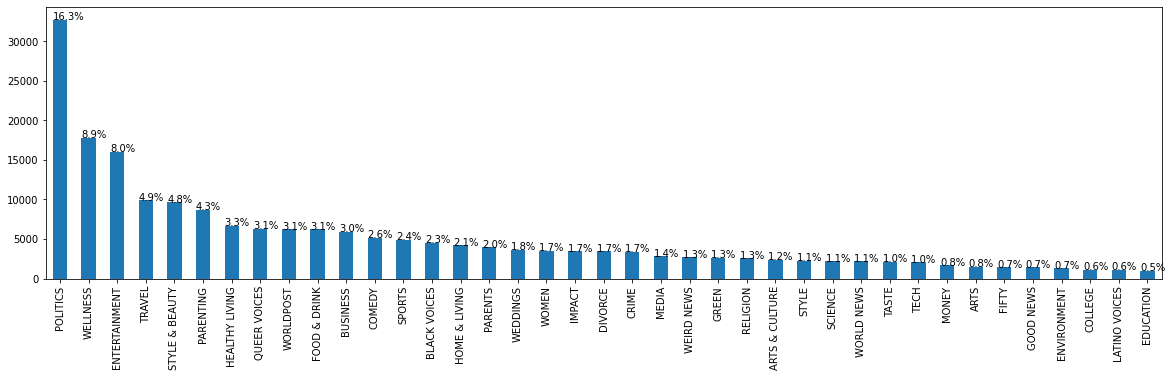

In [0]:
news_count = news_df['cat'].value_counts()
news_percent = [len(news_df[news_df['cat'] == news_cat]) / len(news_df) * 100 for news_cat in news_count.index]

ax = news_count.plot(kind='bar', figsize=(20, 5))
for idx, p in enumerate(ax.patches):
    h = p.get_height()
    x, y = p.get_xy()
    ax.annotate('{:.1f}%'.format(news_percent[idx]), (x, y + h + 0.01))

In [0]:
# from the above fig we can see that groups like 'EDUCATION', 'LATINO VOICES', 'COLLEGE' have very few examples 
# this may give us the problem of skewness or imbalanced classification. We will try to built a basic model to 
# check there is imbalanced classification problem and then use techniques like over sampling or under sampling 
# to tackle it.

In [0]:
# now lets do some text preprocessing

In [0]:
# lets do some text preprocessing
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [0]:
def clean_text(text):
    
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # remove BAD_SYMBOLS_RE symbols in text
    text = ' '.join(word for word in text.split(' ') if word not in STOPWORDS) # remove stopwords from text
    
    return text

In [0]:
news_df['text'] = news_df['text'].apply(clean_text)

In [0]:
# tokenizing is the process of splitting the text into tokens. It create word_index for each token 
# which can be used to convert text sequence into integer sequence
max_words = 10000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(news_df['text'])
sequence = tok.texts_to_sequences(news_df['text'])

In [0]:
len(sequence)

200853

In [0]:
# each of text in the news_df is converted to a sequence of words.
news_df['text'][0], len(news_df['text'][0].split())

('2 mass shootings texas last week  1 tv left husband killed children another day america',
 15)

In [0]:
sequence[0], len(sequence[0])

([211, 1179, 2777, 563, 52, 30, 186, 342, 365, 564, 449, 65, 95, 9, 111], 15)

In [0]:
news_df['text'][1], len(news_df['text'][1].split())

('smith joins diplo nicky jam 2018 world cups official song course song', 12)

In [0]:
sequence[1], len(sequence[1])

([1491, 2761, 5419, 2392, 15, 5878, 824, 835, 418, 835], 10)

In [0]:
word_index = tok.word_index
print(f'Found { len(word_index) } unique tokens.')

Found 112533 unique tokens.


In [0]:
news_df.head()

,text,cat
0,2 mass shootings texas last week 1 tv left husband killed children another day america,CRIME
1,smith joins diplo nicky jam 2018 world cups official song course song,ENTERTAINMENT
2,hugh grant marries first time age 57 actor longtime girlfriend anna eberstein tied knot civil ceremony,ENTERTAINMENT
3,jim carrey blasts castrato adam schiff democrats new artwork actor gives dems asskicking fighting hard enough donald trump,ENTERTAINMENT
4,julianna margulies uses donald trump poop bags pick dog dietland actress said using bags really cathartic therapeutic moment,ENTERTAINMENT


In [0]:
# lets veiw the number of words in the articles on each new group
news_df['word_seq'] = sequence
news_df['num_words'] = news_df['word_seq'].str.len()

In [0]:
news_df.groupby('cat').mean()

,num_words
cat,
ARTS,14.363154
ARTS & CULTURE,14.275222
BLACK VOICES,14.802783
BUSINESS,16.416035
COLLEGE,16.311189
COMEDY,12.389565
CRIME,13.466960
DIVORCE,17.374781
EDUCATION,18.598606


In [0]:
news_df.groupby('cat')['num_words'].min()

cat
ARTS              1
ARTS & CULTURE    1
BLACK VOICES      0
BUSINESS          0
COLLEGE           0
COMEDY            0
CRIME             0
DIVORCE           4
EDUCATION         1
ENTERTAINMENT     0
ENVIRONMENT       5
FIFTY             0
FOOD & DRINK      2
GOOD NEWS         0
GREEN             0
HEALTHY LIVING    0
HOME & LIVING     2
IMPACT            0
LATINO VOICES     1
MEDIA             0
MONEY             8
PARENTING         1
PARENTS           1
POLITICS          0
QUEER VOICES      0
RELIGION          0
SCIENCE           0
SPORTS            1
STYLE             0
STYLE & BEAUTY    1
TASTE             0
TECH              2
TRAVEL            0
WEDDINGS          5
WEIRD NEWS        0
WELLNESS          2
WOMEN             0
WORLD NEWS        3
WORLDPOST         0
Name: num_words, dtype: int64

In [0]:
# its seems like some articles does not have complete text
news_df[news_df['num_words'] <= 3]

,text,cat,word_seq,num_words
557,yanny laurel heres real answer drumroll,WEIRD NEWS,"[116, 101, 735]",3
1486,watch paddleboarder get straightup wrecked dolphin dolphinately porpoise,WEIRD NEWS,"[112, 10]",2
4871,pentagon devours budget normalizing budgetary bloat,POLITICS,"[4712, 903]",2
6637,leaping kangaroo smashes unsuspecting cyclist australia kangaroo hopped away apparently unscathed,WEIRD NEWS,"[2461, 175, 1305]",3
7142,doughnuteating champ arrested doughnut shop breakin doh,CRIME,"[8677, 953, 1340]",3
...,...,...,...,...
191350,conversation designer bibhu mohapatra,STYLE & BEAUTY,"[746, 1057]",2
191905,mothertomother real mothers,PARENTING,"[101, 424]",2
192309,defense london olympics,COMEDY,"[1320, 750, 1217]",3
193389,brazilian decor,HOME & LIVING,"[5443, 3051]",2


In [0]:
len(news_df[news_df['num_words'] <= 3])

3298

In [0]:
# articles having few words are not providing sufficient information for classifying it into any group. 
# also the number of such samples is less, so we can just not consider them
news_df = news_df[news_df['num_words'] > 3]

In [0]:
x_train, x_test, y_train, y_test = train_test_split(news_df['text'], news_df['cat'], test_size=0.3, random_state=33)

In [0]:
# lets try our first baseline model using Naive Bayes Classifier

In [0]:
nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

print('accuracy %s : '% accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.3928830546509862 : 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          ARTS       0.00      0.00      0.00       408
ARTS & CULTURE       1.00      0.00      0.00       681
  BLACK VOICES       0.00      0.00      0.00      1261
      BUSINESS       0.85      0.02      0.03      1728
       COLLEGE       0.00      0.00      0.00       367
        COMEDY       1.00      0.00      0.01      1436
         CRIME       0.76      0.01      0.03       987
       DIVORCE       1.00      0.04      0.08      1049
     EDUCATION       0.00      0.00      0.00       311
 ENTERTAINMENT       0.50      0.72      0.59      4797
   ENVIRONMENT       0.00      0.00      0.00       425
         FIFTY       0.00      0.00      0.00       406
  FOOD & DRINK       0.72      0.41      0.53      1900
     GOOD NEWS       0.00      0.00      0.00       394
         GREEN       0.00      0.00      0.00       750
HEALTHY LIVING       1.00      0.00      0.00      1913
 HOME & LIVING       0.96      0.13      0.23  

In [0]:
# Naive_bayes classification gives us an accuracy of 39%. With this as base benchmark lets try improving accuracy
# using other models

In [0]:
# Linear Support Vector Machine

In [0]:
sgd = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None))
])

sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)

print('accuracy %s : ' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.5595862790423001 : 
                precision    recall  f1-score   support

          ARTS       0.28      0.09      0.14       408
ARTS & CULTURE       0.41      0.23      0.30       681
  BLACK VOICES       0.49      0.25      0.33      1261
      BUSINESS       0.50      0.33      0.40      1728
       COLLEGE       0.45      0.23      0.31       367
        COMEDY       0.47      0.19      0.28      1436
         CRIME       0.54      0.43      0.48       987
       DIVORCE       0.74      0.74      0.74      1049
     EDUCATION       0.50      0.20      0.29       311
 ENTERTAINMENT       0.60      0.69      0.64      4797
   ENVIRONMENT       0.44      0.15      0.22       425
         FIFTY       0.36      0.14      0.20       406
  FOOD & DRINK       0.57      0.72      0.64      1900
     GOOD NEWS       0.30      0.12      0.17       394
         GREEN       0.41      0.19      0.26       750
HEALTHY LIVING       0.36      0.06      0.11      1913
 HOME & LIVING  

In [0]:
# deep learning model

In [0]:
news_df['num_words'].describe()

count    197555.000000
mean         15.549862
std           6.558696
min           4.000000
25%          11.000000
50%          15.000000
75%          19.000000
max         127.000000
Name: num_words, dtype: float64

In [0]:
# our model expects the lenght of all sequence to be same. Now the lenght of the sequences are different corresponding
# to the length of the actual text. We can generalize it to a specific length of 60 by padding.
max_len = 30
data = pad_sequences(news_df['word_seq'], maxlen=max_len)

In [0]:
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  211, 1179, 2777,  563,   52,   30,  186,
        342,  365,  564,  449,   65,   95,    9,  111], dtype=int32)

In [0]:
# one hot encode the labels
encoder = LabelEncoder()
encoder.fit(news_df['cat'])
labels = encoder.transform(news_df['cat'])
n_classes = max(labels) + 1
labels = to_categorical(labels, n_classes)

In [0]:
labels.shape

(197555, 39)

In [0]:
# split the data into train, validation and test sets

In [0]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=20)

In [0]:
x_train.shape, x_test.shape

((138288, 30), (59267, 30))

In [0]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=20)

In [0]:
x_train.shape, x_val.shape

((110630, 30), (27658, 30))

In [0]:
# building a basic and cheap model

model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_len))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 64)            640000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                122944    
_________________________________________________________________
dense_8 (Dense)              (None, 39)                2535      
Total params: 765,479
Trainable params: 765,479
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model.fit(
                x_train, 
                y_train,
                epochs=5,
                batch_size=128,
                validation_data=(x_val, y_val)
            )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 110630 samples, validate on 27658 samples
Epoch 1/5
110630/110630 [==============================] - 9s 80us/step - loss: 2.3897 - accuracy: 0.3894 - val_loss: 1.8844 - val_accuracy: 0.5071
Epoch 2/5
110630/110630 [==============================] - 9s 79us/step - loss: 1.6066 - accuracy: 0.5709 - val_loss: 1.6172 - val_accuracy: 0.5676
Epoch 3/5
110630/110630 [==============================] - 9s 79us/step - loss: 1.3224 - accuracy: 0.6367 - val_loss: 1.5535 - val_accuracy: 0.5832
Epoch 4/5
110630/110630 [==============================] - 9s 77us/step - loss: 1.1025 - accuracy: 0.6941 - val_loss: 1.5717 - val_accuracy: 0.5820
Epoch 5/5
110630/110630 [==============================] - 9s 77us/step - loss: 0.8985 - accuracy: 0.7521 - val_loss: 1.6513 - val_accuracy: 0.5760


In [0]:
def plot_model(history, epch):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, epch+1)

  plt.plot(epochs, acc, 'bo', label='Training_acc')
  plt.plot(epochs, val_acc, 'b', label='Validation_acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training_loss')
  plt.plot(epochs, val_loss, 'b', label='Validation_loss')
  plt.title('Training and Validation loss')
  plt.legend()

  plt.show()

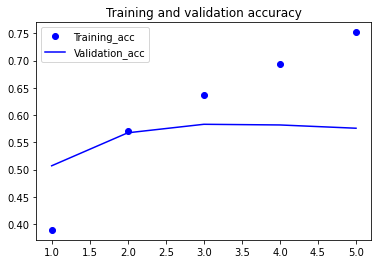

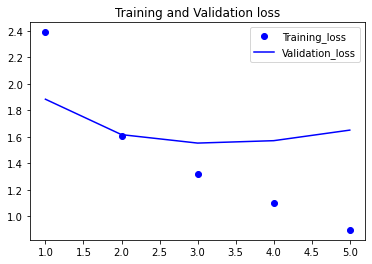

In [0]:
plot_model(history, 5)

In [0]:
# our model starts to overfit after some epochs. Lets try introducing some regularization.

In [0]:
model.evaluate(x_test, y_test)

59267/59267 [==============================] - 2s 35us/step


[1.6675115256069992, 0.5723589658737183]

In [0]:
# we will try introducing regularization to handle overfitting

model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_len))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(n_classes, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 64)            640000    
_________________________________________________________________
flatten_6 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                122944    
_________________________________________________________________
dense_12 (Dense)             (None, 39)                2535      
Total params: 765,479
Trainable params: 765,479
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit(
    x_train,
    y_train,
    epochs=15,
    batch_size=128,
    validation_data=(x_val, y_val)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 110630 samples, validate on 27658 samples
Epoch 1/15
110630/110630 [==============================] - 9s 81us/step - loss: 2.8677 - accuracy: 0.2962 - val_loss: 2.5818 - val_accuracy: 0.3464
Epoch 2/15
110630/110630 [==============================] - 9s 79us/step - loss: 2.4183 - accuracy: 0.3852 - val_loss: 2.3378 - val_accuracy: 0.4114
Epoch 3/15
110630/110630 [==============================] - 9s 80us/step - loss: 2.1689 - accuracy: 0.4576 - val_loss: 2.1303 - val_accuracy: 0.4772
Epoch 4/15
110630/110630 [==============================] - 9s 78us/step - loss: 1.9760 - accuracy: 0.5183 - val_loss: 1.9927 - val_accuracy: 0.5205
Epoch 5/15
110630/110630 [==============================] - 9s 78us/step - loss: 1.8332 - accuracy: 0.5505 - val_loss: 1.9095 - val_accuracy: 0.5329
Epoch 6/15
110630/110630 [==============================] - 9s 78us/step - loss: 1.7344 - accuracy: 0.5729 - val_loss: 1.8486 - val_accuracy: 0.5414
Epoch 7/15
110630/110630 [=============================

In [0]:
# it looks like our model is not able to get accuracy above 56%, lets try adding more layers and see the performance.

In [0]:
model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_len))
model.add(Flatten())
model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(n_classes, activation="softmax"))

In [0]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 30, 64)            640000    
_________________________________________________________________
flatten_10 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                122944    
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 39)                2535      
Total params: 769,639
Trainable params: 769,639
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
    optimizer="rmsprop", 
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [0]:
model.fit(
    x_train, 
    y_train,
    epochs=20,
    batch_size=128,
    validation_data=(x_val, y_val)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 110630 samples, validate on 27658 samples
Epoch 1/20
110630/110630 [==============================] - 9s 80us/step - loss: 2.9860 - accuracy: 0.2731 - val_loss: 2.6970 - val_accuracy: 0.3297
Epoch 2/20
110630/110630 [==============================] - 9s 78us/step - loss: 2.5576 - accuracy: 0.3512 - val_loss: 2.5391 - val_accuracy: 0.3531
Epoch 3/20
110630/110630 [==============================] - 9s 82us/step - loss: 2.4301 - accuracy: 0.3724 - val_loss: 2.4511 - val_accuracy: 0.3741
Epoch 4/20
110630/110630 [==============================] - 9s 78us/step - loss: 2.3146 - accuracy: 0.4122 - val_loss: 2.3369 - val_accuracy: 0.4168
Epoch 5/20
110630/110630 [==============================] - 9s 78us/step - loss: 2.1937 - accuracy: 0.4461 - val_loss: 2.2803 - val_accuracy: 0.4293
Epoch 6/20
110630/110630 [==============================] - 9s 78us/step - loss: 2.1120 - accuracy: 0.4674 - val_loss: 2.2430 - val_accuracy: 0.4482
Epoch 7/20
110630/110630 [=============================

In [0]:
# lets now try using pretrained word embedding - GloVe word embedding
!curl -LO http://nlp.stanford.edu/data/glove.6B.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   308    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   345    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  822M  100  822M    0     0  2165k      0  0:06:28  0:06:28 --:--:-- 2176k


In [0]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
embeddings_index = {}

with open("glove.6B.100d.txt", "r") as file:
    for line in file:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coeffs

In [0]:
print(f"there are {len(embeddings_index)} tokens.")

there are 400000 tokens.


In [0]:
# creating the embedding matrix
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix[2]

array([-0.22556999,  0.49417999,  0.48609999, -0.4332    ,  0.13738   ,
        0.50616997,  0.26058   ,  0.30103001, -0.091486  ,  0.10876   ,
        0.30579999,  0.051028  ,  0.22303   ,  0.054236  ,  0.068838  ,
       -0.24700999,  0.32688999, -0.082203  , -0.28865999,  0.3734    ,
        0.73803997, -0.040969  ,  0.040201  ,  0.11384   ,  0.69986999,
       -0.49744999, -0.06755   , -0.42598999, -0.10725   , -0.010697  ,
       -0.01479   ,  0.55975997,  0.3064    ,  0.053053  ,  0.058034  ,
        0.32756001, -0.37233001,  0.46513   ,  0.14285   , -0.085003  ,
       -0.45475999,  0.19773   ,  0.6383    , -0.31147999,  0.10858   ,
        0.31557   ,  0.36682001, -0.35135001, -0.48414001, -0.33234999,
       -0.33816001, -0.39678001,  0.1908    ,  1.3513    , -0.39043999,
       -2.87949991, -0.14275999, -0.087754  ,  1.77129996,  0.99331999,
       -0.14128999,  0.94388998,  0.050897  ,  0.47373   ,  0.86387002,
       -0.16162001,  0.67198998,  0.52344   ,  0.14438   , -0.05

In [0]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(n_classes, activation="softmax"))

In [0]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 30, 100)           1000000   
_________________________________________________________________
flatten_12 (Flatten)         (None, 3000)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                192064    
_________________________________________________________________
dense_25 (Dense)             (None, 39)                2535      
Total params: 1,194,599
Trainable params: 1,194,599
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [0]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [0]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val)
)

Train on 110630 samples, validate on 27658 samples
Epoch 1/10
110630/110630 [==============================] - 5s 46us/step - loss: 2.0437 - accuracy: 0.4565 - val_loss: 1.8307 - val_accuracy: 0.4931
Epoch 2/10
110630/110630 [==============================] - 5s 44us/step - loss: 1.6671 - accuracy: 0.5347 - val_loss: 1.8190 - val_accuracy: 0.5004
Epoch 3/10
110630/110630 [==============================] - 5s 44us/step - loss: 1.5358 - accuracy: 0.5647 - val_loss: 1.8393 - val_accuracy: 0.4984
Epoch 4/10
110630/110630 [==============================] - 5s 44us/step - loss: 1.4409 - accuracy: 0.5871 - val_loss: 1.8608 - val_accuracy: 0.4986
Epoch 5/10
110630/110630 [==============================] - 5s 44us/step - loss: 1.3634 - accuracy: 0.6076 - val_loss: 1.9154 - val_accuracy: 0.4966
Epoch 6/10
110630/110630 [==============================] - 5s 45us/step - loss: 1.2995 - accuracy: 0.6226 - val_loss: 1.9753 - val_accuracy: 0.4881
Epoch 7/10
110630/110630 [=============================

In [0]:
model.evaluate(x_test, y_test)

59267/59267 [==============================] - 2s 34us/step


[2.2618018843262875, 0.4719827175140381]

In [0]:
# it seems like the combination of Embedding and Dense layer are not able to perform well on text problem.
# lets try implementing some advanced architecture which are tuned to work with sequence data.

In [0]:
model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_len))
model.add(SimpleRNN(64))
model.add(Dense(n_classes, activation="softmax"))

In [0]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [0]:
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 110630 samples, validate on 27658 samples
Epoch 1/10
110630/110630 [==============================] - 17s 155us/step - loss: 2.7116 - accuracy: 0.3047 - val_loss: 2.3531 - val_accuracy: 0.3759
Epoch 2/10
110630/110630 [==============================] - 17s 154us/step - loss: 2.1051 - accuracy: 0.4470 - val_loss: 2.0788 - val_accuracy: 0.4609
Epoch 3/10
110630/110630 [==============================] - 17s 153us/step - loss: 1.8228 - accuracy: 0.5227 - val_loss: 1.8792 - val_accuracy: 0.5101
Epoch 4/10
110630/110630 [==============================] - 17s 154us/step - loss: 1.6394 - accuracy: 0.5672 - val_loss: 1.8441 - val_accuracy: 0.5239
Epoch 5/10
110630/110630 [==============================] - 17s 153us/step - loss: 1.5090 - accuracy: 0.5974 - val_loss: 1.7770 - val_accuracy: 0.5434
Epoch 6/10
110630/110630 [==============================] - 17s 155us/step - loss: 1.4023 - accuracy: 0.6247 - val_loss: 1.7577 - val_accuracy: 0.5415
Epoch 7/10
110630/110630 [=================

In [0]:
# let us try using LSTM layer

model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_len))
model.add(LSTM(64))
model.add(Dense(64, activation="relu"))
model.add(Dense(n_classes, activation="softmax"))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 64)            640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 39)                2535      
Total params: 679,719
Trainable params: 679,719
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [0]:
model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 110630 samples, validate on 27658 samples
Epoch 1/10
110630/110630 [==============================] - 50s 448us/step - loss: 2.5128 - accuracy: 0.3477 - val_loss: 2.0743 - val_accuracy: 0.4576
Epoch 2/10
110630/110630 [==============================] - 49s 443us/step - loss: 1.8238 - accuracy: 0.5210 - val_loss: 1.7925 - val_accuracy: 0.5280
Epoch 3/10
110630/110630 [==============================] - 49s 443us/step - loss: 1.5838 - accuracy: 0.5768 - val_loss: 1.6437 - val_accuracy: 0.5646
Epoch 4/10
110630/110630 [==============================] - 49s 442us/step - loss: 1.4295 - accuracy: 0.6140 - val_loss: 1.6205 - val_accuracy: 0.5714
Epoch 5/10
110630/110630 [==============================] - 49s 441us/step - loss: 1.3171 - accuracy: 0.6375 - val_loss: 1.5516 - val_accuracy: 0.5888
Epoch 6/10
110630/110630 [==============================] - 49s 442us/step - loss: 1.2312 - accuracy: 0.6585 - val_loss: 1.5375 - val_accuracy: 0.5938
Epoch 7/10
110630/110630 [=================

In [0]:
model.evaluate(x_test, y_test)

59267/59267 [==============================] - 9s 155us/step


[1.5690422438701446, 0.5901091694831848]

In [0]:
model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_len))
model.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation="relu"))
model.add(Dense(n_classes, activation="softmax"))

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 64)            640000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 39)                2535      
Total params: 712,743
Trainable params: 712,743
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [0]:
model.fit(
    x_train, 
    y_train, 
    batch_size=128,
    epochs=20,
    validation_data=(x_val, y_val)
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 110630 samples, validate on 27658 samples
Epoch 1/20
110630/110630 [==============================] - 93s 843us/step - loss: 2.7107 - accuracy: 0.2952 - val_loss: 2.2446 - val_accuracy: 0.4080
Epoch 2/20
110630/110630 [==============================] - 92s 836us/step - loss: 2.0610 - accuracy: 0.4615 - val_loss: 1.8930 - val_accuracy: 0.5059
Epoch 3/20
110630/110630 [==============================] - 92s 828us/step - loss: 1.7843 - accuracy: 0.5316 - val_loss: 1.7260 - val_accuracy: 0.5425
Epoch 4/20
110630/110630 [==============================] - 92s 832us/step - loss: 1.6261 - accuracy: 0.5662 - val_loss: 1.6257 - val_accuracy: 0.5656
Epoch 5/20
110630/110630 [==============================] - 92s 833us/step - loss: 1.5140 - accuracy: 0.5930 - val_loss: 1.5663 - val_accuracy: 0.5811
Epoch 6/20
110630/110630 [==============================] - 92s 832us/step - loss: 1.4313 - accuracy: 0.6119 - val_loss: 1.5145 - val_accuracy: 0.5922
Epoch 7/20
110630/110630 [=================

In [0]:
model.evaluate(x_test, y_test)

23296/59267 [==========>...................] - ETA: 11s